# Time Series Forecasting

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Load clean dataset
df = pd.read_csv("../data/daily_revenue_processed.csv", parse_dates=['date'])
df.set_index('date', inplace=True)

# Pastikan time series harian & lengkap
ts = df['daily_revenue'].asfreq('D').fillna(0)

Text(0.5, 1.0, 'Train-Test Split')

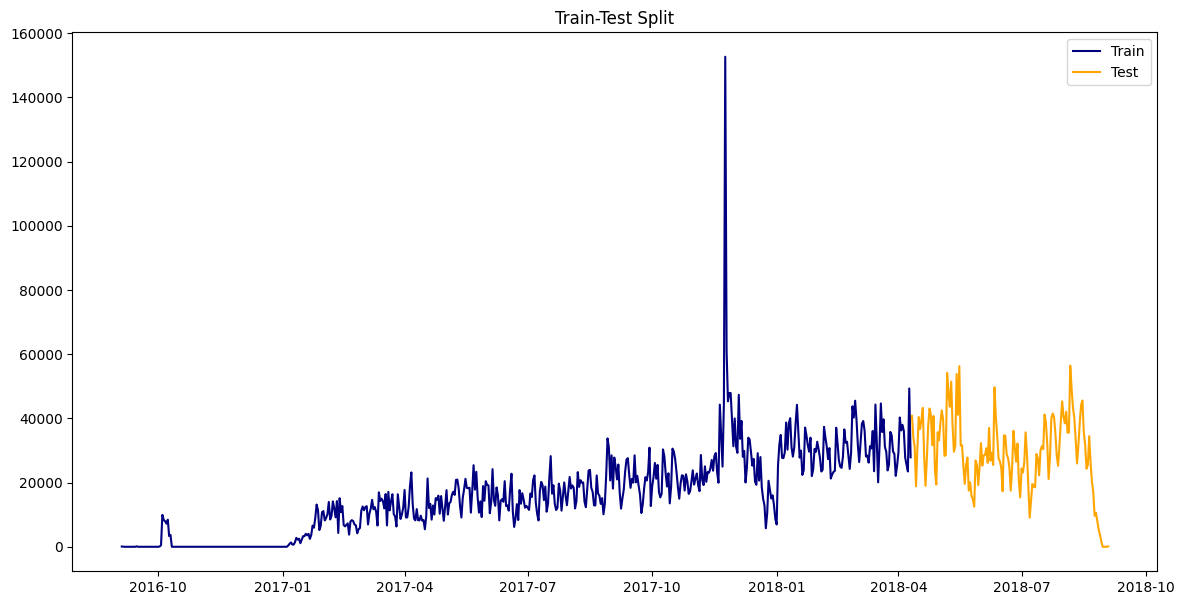

In [7]:
# Train-Test split: ambil 80% sebagai train
split_idx = int(len(ts)*0.8)
train = ts.iloc[:split_idx]
test = ts.iloc[split_idx:]
# Plot train-test split
plt.figure(figsize=(14, 7))
plt.plot(train, label='Train', color='navy')
plt.plot(test, label='Test', color='orange')
plt.legend()
plt.title("Train-Test Split")

## Model ARIMA

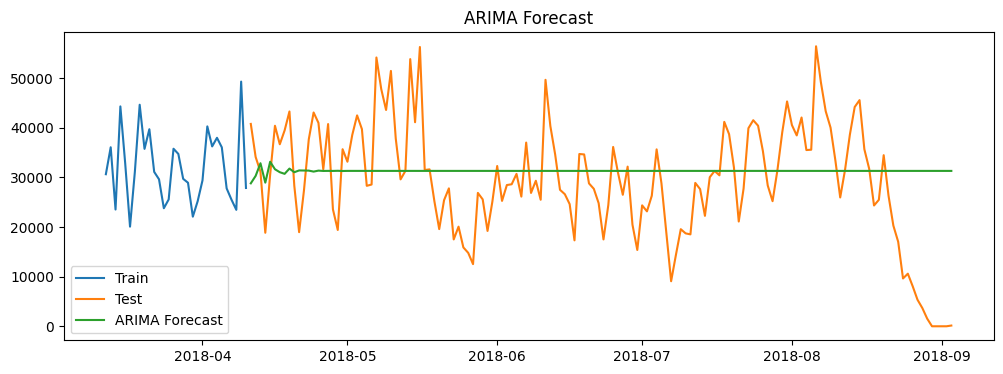

ARIMA RMSE: 12005.583151844976


In [9]:
# Fit ARIMA
model_arima = ARIMA(train, order=(5,1,0))  # (p,d,q)
model_fit = model_arima.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))
plt.figure(figsize=(12,4))
plt.plot(train[-30:], label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast, label='ARIMA Forecast')
plt.legend()
plt.title("ARIMA Forecast")
plt.show()

# Evaluation
rmse_arima = sqrt(mean_squared_error(test, forecast))
print("ARIMA RMSE:", rmse_arima)


Secara visual dan RMSE, model ARIMA tidak dapat melakukan forecasting dengan baik karena hasil prediksi bernilai tetap

## Model Prophet

10:17:00 - cmdstanpy - INFO - Chain [1] start processing
10:17:01 - cmdstanpy - INFO - Chain [1] done processing


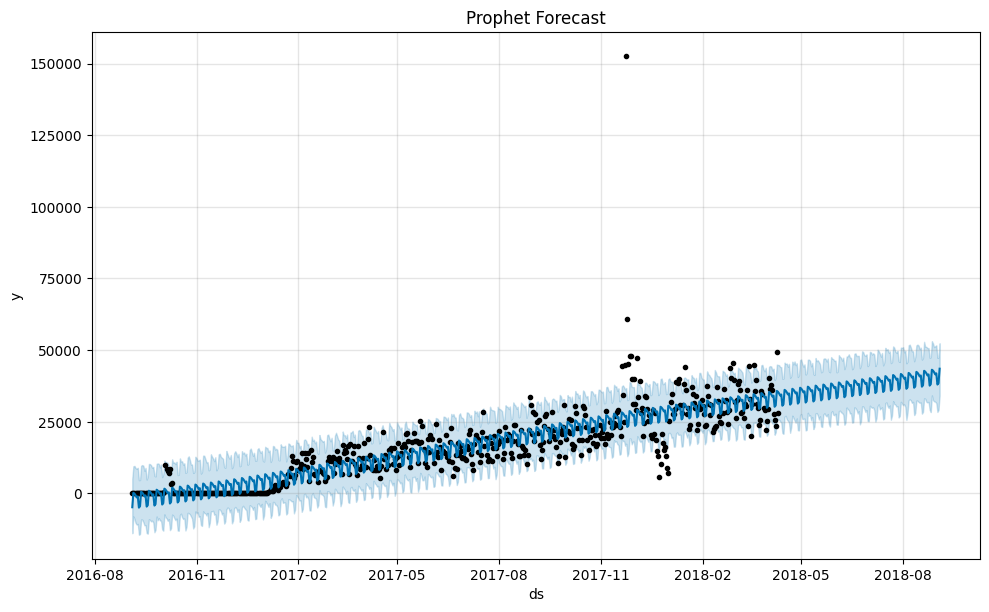

Prophet RMSE: 14647.651664927651


In [13]:
df_prophet = ts.reset_index()
df_prophet.columns = ['ds', 'y']

model_prophet = Prophet()
model_prophet.fit(df_prophet.iloc[:split_idx])

future = model_prophet.make_future_dataframe(periods=len(test))
forecast = model_prophet.predict(future)

# Plot
model_prophet.plot(forecast)
plt.title("Prophet Forecast")
plt.show()

# Evaluation
predicted = forecast.iloc[-len(test):]['yhat'].values
rmse_prophet = sqrt(mean_squared_error(test, predicted))
print("Prophet RMSE:", rmse_prophet)


Model Prophet tidak dapat mengikuti dinamika revenue dengan baik ditandai nilai RMSE yang sangat besar tetapi dapat mengikuti tren secara umum yang menaik

## Model Random Forest

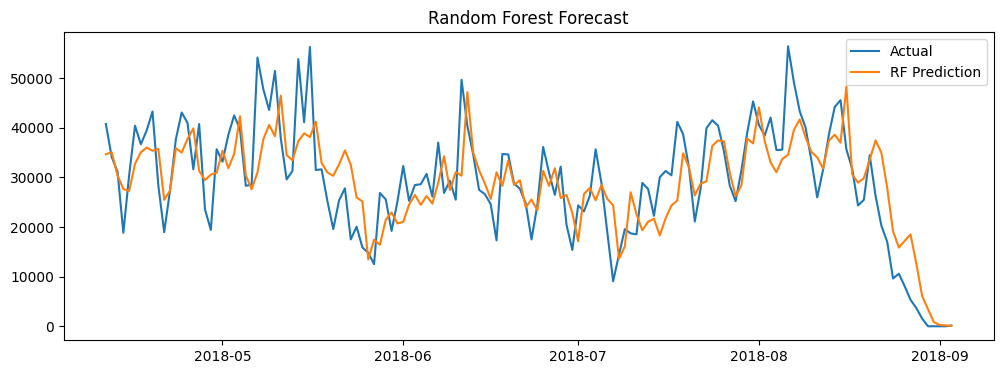

Random Forest RMSE: 7441.510417184305


In [15]:
# Buat fitur lag
df_ml = pd.DataFrame(ts)
for i in range(1, 8):  # lag 7 hari
    df_ml[f'lag_{i}'] = df_ml['daily_revenue'].shift(i)

df_ml.dropna(inplace=True)

# Train-test
X = df_ml.drop('daily_revenue', axis=1)
y = df_ml['daily_revenue']

X_train = X.iloc[:split_idx - 7]
y_train = y.iloc[:split_idx - 7]
X_test = X.iloc[split_idx - 7:]
y_test = y.iloc[split_idx - 7:]

# Fit model
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Plot
plt.figure(figsize=(12,4))
plt.plot(y_test.index, y_test.values, label="Actual")
plt.plot(y_test.index, y_pred, label="RF Prediction")
plt.title("Random Forest Forecast")
plt.legend()
plt.show()

# Evaluation
rmse_rf = sqrt(mean_squared_error(y_test, y_pred))
print("Random Forest RMSE:", rmse_rf)

In [16]:
print("Model Comparison:")
print(f"ARIMA        RMSE: {rmse_arima:.2f}")
print(f"Prophet      RMSE: {rmse_prophet:.2f}")
print(f"RandomForest RMSE: {rmse_rf:.2f}")


Model Comparison:
ARIMA        RMSE: 12005.58
Prophet      RMSE: 14647.65
RandomForest RMSE: 7441.51


- Model random forest regressor lebih baik dibandingkan kedua model lainnya, secara visual dapat mengikuti tren revenue dan nilai RMSE yang lebih rendah
- Model Machine Learning lebih baik dari model klasik